In [1]:
import requests
import os
from langchain.tools import tool

In [2]:
JIRA_API_URL = "https://your-company.atlassian.net/rest/api/2/issue"
JIRA_USER = "your-jira-email"
JIRA_TOKEN = os.getenv("JIRA_API_TOKEN") # Store this securely!

CAB_SERVICE_API_URL = "https://api.yourcabservice.com/v1/bookings"
CAB_SERVICE_API_KEY = os.getenv("CAB_API_KEY")

@tool
def book_cab(pickup: str, destination: str, time: str) -> str:
    """Books a cab for the specified route and time."""
    print(f"--- Calling Cab Service API ---")
    # In a real scenario, you would make an API call like this:
    # headers = {"Authorization": f"Bearer {CAB_SERVICE_API_KEY}"}
    # payload = {"pickup": pickup, "destination": destination, "time": time}
    # response = requests.post(CAB_SERVICE_API_URL, json=payload, headers=headers)
    # if response.status_code == 201:
    #     return f"Successfully booked a cab from {pickup} to {destination} for {time}."
    # else:
    #     return f"Failed to book cab. Service returned: {response.text}"
    return f"CAB BOOKED: From {pickup} to {destination} at {time}. (This is a mock response)."

@tool
def create_ticket(summary: str, description: str) -> str:
    """Creates an IT support ticket in Jira or a similar system."""
    print(f"--- Calling Jira API ---")
    # In a real scenario, you would make an API call like this:
    # auth = (JIRA_USER, JIRA_TOKEN)
    # headers = {"Accept": "application/json", "Content-Type": "application/json"}
    # payload = {
    #     "fields": {
    #         "project": {"key": "IT"},
    #         "summary": summary,
    #         "description": description,
    #         "issuetype": {"name": "Task"}
    #     }
    # }
    # response = requests.post(JIRA_API_URL, json=payload, headers=headers, auth=auth)
    # if response.status_code == 201:
    #     ticket_key = response.json()['key']
    #     return f"Successfully created ticket {ticket_key} with summary: '{summary}'."
    # else:
    #     return f"Failed to create ticket. Jira returned: {response.text}"
    return f"TICKET CREATED: '{summary}'. (This is a mock response)."

In [16]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
#from langchain.tools.render import format_tool_to_openai_tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated, List
import operator
from langchain_tavily import TavilySearch
from dotenv import load_dotenv

load_dotenv()

# 1. Define the tools
searchtool = TavilySearch(max_results=2)
@tool
def book_cab(pickup: str, destination: str, time: str) -> str:
    """Books a cab for the specified route and time."""
    print(f"--- Calling Cab Service API ---")
    # In a real scenario, you would make an API call like this:
    # headers = {"Authorization": f"Bearer {CAB_SERVICE_API_KEY}"}
    # payload = {"pickup": pickup, "destination": destination, "time": time}
    # response = requests.post(CAB_SERVICE_API_URL, json=payload, headers=headers)
    # if response.status_code == 201:
    #     return f"Successfully booked a cab from {pickup} to {destination} for {time}."
    # else:
    #     return f"Failed to book cab. Service returned: {response.text}"
    return f"CAB BOOKED: From {pickup} to {destination} at {time}. (This is a mock response)."

@tool
def create_ticket(summary: str, description: str) -> str:
    """Creates an IT support ticket in Jira or a similar system."""
    print(f"--- Calling Jira API ---")
    # In a real scenario, you would make an API call like this:
    # auth = (JIRA_USER, JIRA_TOKEN)
    # headers = {"Accept": "application/json", "Content-Type": "application/json"}
    # payload = {
    #     "fields": {
    #         "project": {"key": "IT"},
    #         "summary": summary,
    #         "description": description,
    #         "issuetype": {"name": "Task"}
    #     }
    # }
    # response = requests.post(JIRA_API_URL, json=payload, headers=headers, auth=auth)
    # if response.status_code == 201:
    #     ticket_key = response.json()['key']
    #     return f"Successfully created ticket {ticket_key} with summary: '{summary}'."
    # else:
    #     return f"Failed to create ticket. Jira returned: {response.text}"
    return f"TICKET CREATED: '{summary}'. (This is a mock response)."

tool_executor = ToolNode([searchtool, book_cab, create_ticket])
llm = ChatGroq(model="llama3-8b-8192")
#llm = ChatGroq(temperature=0, model="gpt-4-1106-preview")

llm_with_tools = llm.bind(tools=[convert_to_openai_tool(t) for t in [searchtool,book_cab, create_ticket]])

# 2. Define the agent's state
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # This will hold the details for the modal form if needed
    action_request: dict

# 3. Define the nodes of the graph

def should_continue(state: AgentState):
    """Decides the next step: call a tool, ask for info, or end."""
    last_message = state["messages"][-1]
    # If the LLM made a tool call
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Check if we have all arguments for the tool
        tool_call = last_message.tool_calls[0]
        tool_name = tool_call['name']
        all_args_present = all(arg in tool_call['args'] for arg in tool_executor.tools_by_name[tool_name].args)

        if all_args_present:
            return "call_tool"
        else:
            # Not all arguments are present, request them from the user
            return "request_info"
    # Otherwise, the conversation is over
    return END

def call_model(state: AgentState):
    """The primary node that calls the LLM."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tool(state: AgentState):
    """Node that executes a tool and returns the result."""
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    action = {"tool": tool_call['name'], "tool_input": tool_call['args']}
    
    response = tool_executor.invoke(action)
    tool_message = ToolMessage(content=str(response), tool_call_id=tool_call['id'])
    
    return {"messages": [tool_message]}

def request_info(state: AgentState):
    """Node that prepares a request for more information from the user."""
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    tool_name = tool_call['name']
    
    # Get the required arguments for the tool from its signature
    required_args = list(tool_executor.tools_by_name[tool_name].args.keys())
    
    # Prepare the action request for the frontend
    action_request = {
        "action_required": True,
        "tool_name": tool_name,
        "required_fields": required_args,
    }
    return {"action_request": action_request}


# 4. Wire up the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.add_node("request_info", request_info)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "call_tool": "action",
        "request_info": "request_info",
        END: END,
    },
)

workflow.add_edge("action", "agent")
workflow.add_edge("request_info", END) # Stop here and wait for frontend

# Compile the graph
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [17]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# 4. Wire up the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.add_node("request_info", request_info)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "call_tool": "action",
        "request_info": "request_info",
        END: END,
    },
)

workflow.add_edge("action", "agent")
workflow.add_edge("request_info", END) 



In [20]:
workflow

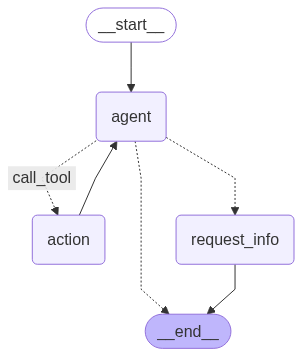

In [21]:
workflow.compile()